# Quantum Machine Learning with MNIST dataset

This notebook is retreived from [here](https://github.com/ML4SCI/QML-hands-on/tree/main) and modified to fit the lecture.

In [27]:
import pennylane as qml
import pennylane.numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Data

Next we will download the MNIST dataset from keras and normalize it.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[..., np.newaxis] / 255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In order to simplify the problem, we will restrict us to a subset of the full dataset.

In [3]:
n_train_per_class = 200
n_test_per_class = 1000

Furthermore, we will limit to the images of threes and sixes, to have a binary classification problem.
To do so, we filter out the images from the training data based on the label.

In [4]:
def filter_36(x, y, n_samples):
    keep3 = y == 3
    keep6 = y == 6
    x = np.concatenate((x[keep3][:n_samples], x[keep6][:n_samples]))
    y = np.concatenate((y[keep3][:n_samples], y[keep6][:n_samples]))
    y = y == 3
    y = 2 * y - 1
    return shuffle(x, y, random_state=0)

In [5]:
x_train, y_train = filter_36(x_train, y_train, n_train_per_class)
x_test, y_test = filter_36(x_test, y_test, n_test_per_class)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 400
Number of filtered test examples: 1958


Let's have a look at an example image

1


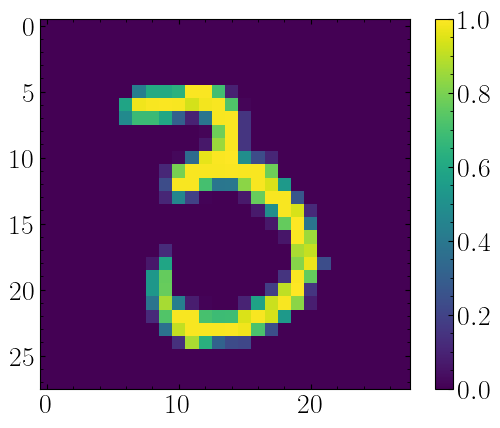

In [18]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()
plt.show()

A single images has 28x28=784 pixels, which are the features of our classification task. To use a smaller amount of qubits, we will reduce the dimensionality of the dataset.
In this example we will use a data embedding of a single feature per qubit, therefore reducing the dataset to the number of qubits.

To do we will use a principle component analysis. Now this is a very simple technique for dimensionality reduction, however, we need to be careful with the interpretation of the results. Although the PCA is quite simple, it can be a powerful tool on simple datasets like MNIST.

The resulting principle components might already seperate the two classes sufficiently, that a cut on a single feature after the PCA gives a good calssification accuracy.

In [19]:
n_qubits = 3
n_features = n_qubits

In [20]:
pca = PCA(n_components=n_features)
x_train = pca.fit_transform(x_train.reshape(-1, 28 * 28))
cumsum = np.cumsum(pca.explained_variance_ratio_ * 100)[-1]
print("Cumulative sum on train :", cumsum)

x_test = pca.transform(x_test.reshape(-1, 28 * 28))
cumsum = np.cumsum(pca.explained_variance_ratio_ * 100)[-1]
print("Cumulative sum on train :", cumsum)

Cumulative sum on train : 33.99260841359752
Cumulative sum on train : 33.99260841359752


In [21]:
norm = np.max(x_train)

x_train = x_train / norm * np.pi
x_test = x_test / norm * np.pi

As an example we will plot a single principle

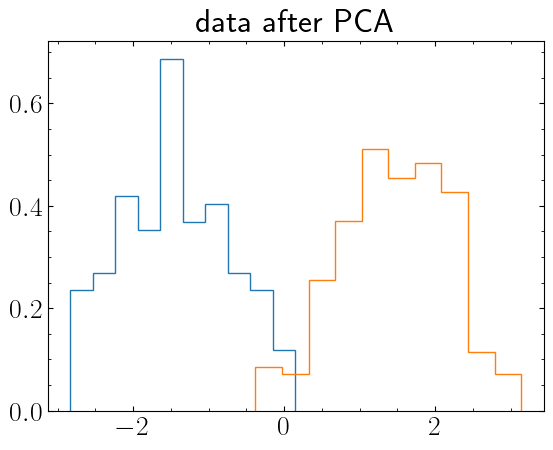

In [24]:
plt.hist(x_train[:, 0][y_train == -1], histtype="step", density=True)
plt.hist(x_train[:, 0][y_train == 1], histtype="step", density=True)
plt.title("data after PCA")
plt.savefig("postpca")
plt.show()

As we can see, the PCA already separates the two classes on the first component sufficiently, so that the classification becomes a trivial problem.

## Circuit setup

In [32]:
dev = qml.device("lightning.qubit", wires=n_qubits)

In [33]:
layers = 3
parameter_shape = qml.StronglyEntanglingLayers.shape(layers, 3)

In [34]:
@qml.qnode(dev)
def training_circuit(data, params):
    qml.AngleEmbedding(data, wires=range(3), rotation="X")  # Try with other embeddings
    qml.StronglyEntanglingLayers(params, wires=range(3))
    return qml.expval(qml.PauliZ(0))

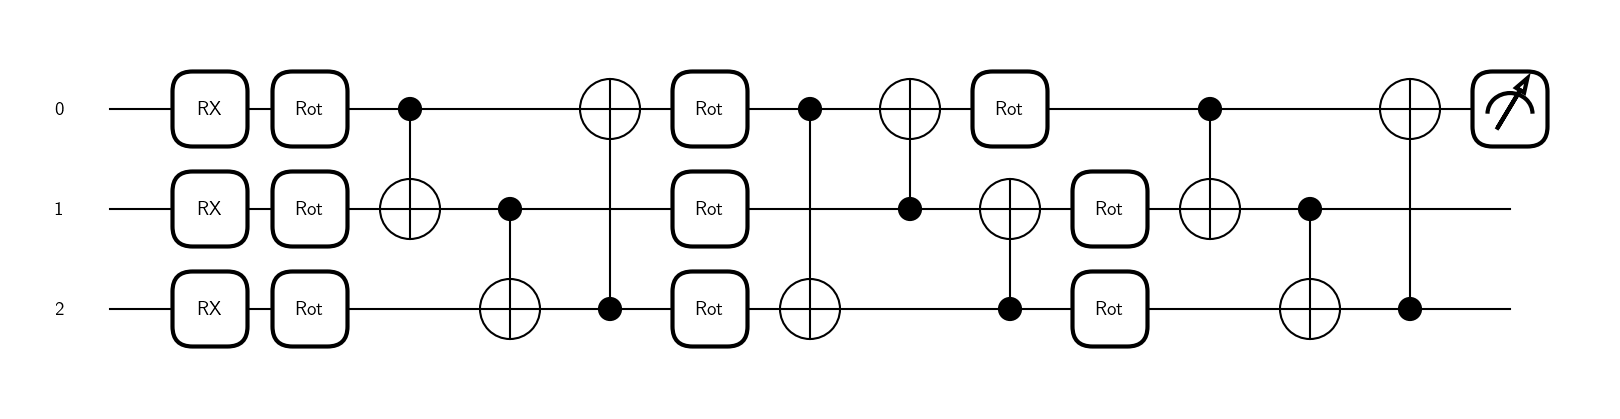

In [38]:
qml.draw_mpl(training_circuit, style="black_white", expansion_strategy="device")(
    x_train[0], np.random.random(parameter_shape)
)
plt.show()

# Training

To train the circuit, we will define a loss function and an optimizer which will train our parameters while we loop over the training data.

In our training dataset we assigned the labels $1$ and $-1$ to our two classes.
In our training circuit we are measuring in the PauliZ basis. Since $\sigma_z$ has eigenvalues $\pm 1$ the measurement results exaclty corresponds to the label of the class.

We can therefore write down a simple loss function. Here we will use the [Hinge loss](https://en.wikipedia.org/wiki/Hinge_loss), which expects the labels to be $\pm 1$.

Note, that we construct the loss function to take in a batch of data and the parameters of the circuit.

In [39]:
def loss(batch_x, batch_y, params):
    loss = 0
    for idx, x in enumerate(batch_x):
        y_pred = training_circuit(x, params)
        loss += np.maximum(1 - batch_y[idx] * y_pred, 0)
    return loss / len(batch_x)

Like in th eprevious examples we will now define our initial parameters. Here we again have to specify the keyword **requires_grad** to indicate that these are parameters we want to optimize.

In [41]:
params = np.random.uniform(-np.pi, np.pi, size=parameter_shape, requires_grad=True)

To loop over our data we furthermore write a function to split our data into batches

In [42]:
def iterate_minibatches(dataX, dataY, batch_size):
    for start_idx in range(0, dataX.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield dataX[idxs], dataY[idxs]

In [43]:
def accuracy(dataX, dataY, params):
    acc = 0
    for idx, x in enumerate(dataX):
        pred = -1 if training_circuit(x, params) < 0 else 1
        if pred == dataY[idx]:
            acc += 1
    return acc / len(dataX)

Now we are ready to train!
We define the training parameters and the optimizer

In [44]:
epochs = 10
batch_size = 16
lr = 0.01

In [45]:
opt = qml.AdamOptimizer(stepsize=lr)

And write down the training loop. Note, that we define the cost function with a [lambda function](https://www.w3schools.com/python/python_lambda.asp) for every batch of data, since our optimizer expects a function with a single argrument, which will be optimized.

For every epoch, we loop over all batches of data and perform an optimzation step for every batch.

In [46]:
import time

start = time.time()

loss_hist = []
acc_hist = []

for it in range(epochs):
    for j, data in enumerate(
        iterate_minibatches(x_train, y_train, batch_size=batch_size)
    ):
        Xbatch, Ybatch = data
        cost_fn = lambda p: loss(Xbatch, Ybatch, p)
        params = opt.step(cost_fn, params)
        print(j, end="\r")

    loss_val = loss(x_train, y_train, params)
    acc = accuracy(x_train, y_train, params)

    loss_hist += [loss_val]
    acc_hist += [acc]

    print(f"Epoch: {it} | Loss: {loss_val:.3} | acc: {acc:.3} ")
    print("____")

end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

Epoch: 0 | Loss: 0.654 | acc: 0.843 
____
Epoch: 1 | Loss: 0.495 | acc: 0.953 
____
Epoch: 2 | Loss: 0.416 | acc: 0.963 
____
Epoch: 3 | Loss: 0.381 | acc: 0.963 
____
Epoch: 4 | Loss: 0.363 | acc: 0.96 
____
Epoch: 5 | Loss: 0.344 | acc: 0.965 
____
Epoch: 6 | Loss: 0.302 | acc: 0.973 
____
Epoch: 7 | Loss: 0.253 | acc: 0.973 
____
Epoch: 8 | Loss: 0.234 | acc: 0.978 
____
Epoch: 9 | Loss: 0.23 | acc: 0.978 
____
Time for 10 epochs: 213.51178622245789


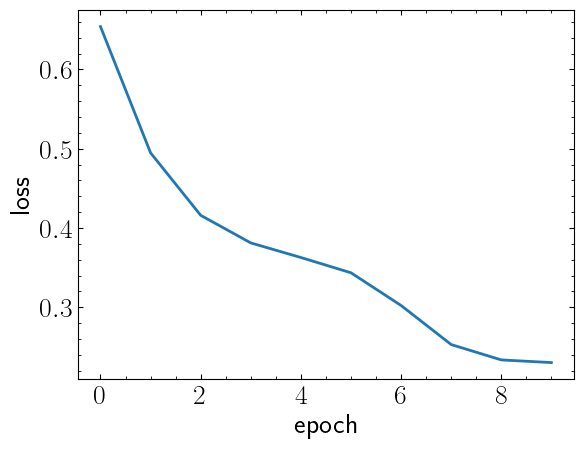

In [48]:
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

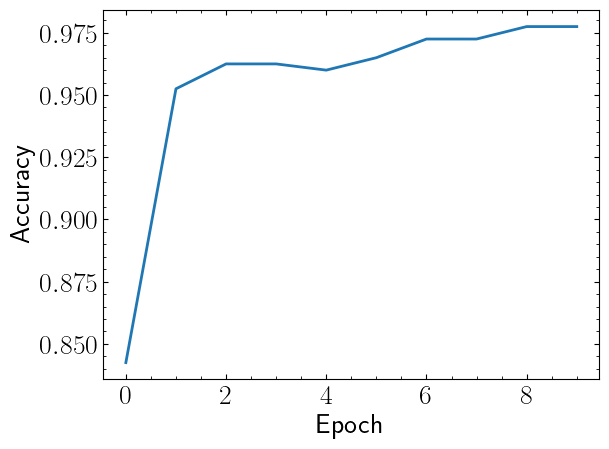

In [49]:
plt.plot(acc_hist)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()